## Import packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random
import csv

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)

## Define variables that will apply to all models:

In [2]:
# input and output folder
input_folder = "/kaggle/input/"
output_folder = "/kaggle/working/"

n_epochs = 1
batch_size = 128 # How big of a set of data to use for every training epoch

### Create a file to save test results

In [3]:
# Open the excel file where I'll save all the test results (metrics)

with open("./results.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow(["model_name",
                         "removed_layer", 
                         "test_loss",
                         "test_accuracy",
                         "wa_precision", # wa = weighted average
                         "wa_recall",
                         "wa_f1_score",
                         "wrong_preds",
                         "total_preds",
                         "batch_size",
                         "num_train", # number of images in the training set
                         "num_val", # number of images in the validation set
                         "num_test", # number of images in the test set
                         "num_epochs_set", # cap set for num epochs
                         "num_epochs_run" # epoch where it stopped automatically
                        ])
    
# ADD A WAY TO PROPERLY DESCRIBE THE MODEL ARCHITECTURE: MAYBE GIVE A NAME TO EACH LAYER
# OF THE VGG, AND THEN LIST THE LAYER(S) REMOVED IN EACH SPECIFIC ITERATION.

# TODO

1. ADD A WAY TO PROPERLY DESCRIBE THE MODEL ARCHITECTURE IN THE EXCEL FILE
2. IN THE IMAGES (TRAINING ACCURACY, TRAINING LOSS, CONFUSION MATRIX), ADD THE NAME OF THE MODEL IN THE IMAGE TITLE.

### Define functions

In [4]:
# https://stackoverflow.com/questions/39280813/visualization-of-convolutional-layer-in-keras-model
# Merdan Memtimin https://stackoverflow.com/users/6565409/merdan-memtimin
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [5]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


In [6]:
def precision(confusion_matrix):
    """Given a confusion matrix, calculates and returns precision for all classes"""
    precision_list = []
    for i in range(confusion_matrix.shape[1]):
        current_col = confusion_matrix[:,[i]]
        current_el = confusion_matrix[i,[i]]
        current_precision = (float(current_el/sum(current_col)[0]))
        current_precision = round(current_precision, 4)
        precision_list.append(current_precision)
    return precision_list

def recall(confusion_matrix):
    """Given a confusion matrix, calculates and returns recall for all classes"""
    recall_list = []
    for i in range(confusion_matrix.shape[0]):
        current_row = confusion_matrix[i,:]
        current_el = confusion_matrix[i,i]
        current_recall = round(current_el/sum(current_row), 4)
        recall_list.append(current_recall)
    return(recall_list)

def f1_score(precision, recall):
    """Given a list of precision and recall values for a certain matrix,
    returns f-1 values for each class"""
    f1_scores = []
    if len(precision) == len(recall):
        for i in range(len(precision)):
            current_f1 = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
            f1_scores.append(round(current_f1, 4))
    else:
        print("Error. Precision and Recall lists should be of equal lengths.")
    return f1_scores

## Load data

In [7]:
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

## Preprocessing

In [8]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

In [9]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, # for replicability. Anyways they are already shuffled.
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Building training set.
Found 18900 validated image filenames belonging to 10 classes.

Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

Building test set
Found 2700 validated image filenames belonging to 10 classes.


In [10]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)

# Ablation
For this ablations study, I am going to focus on VGG16, as it is a simpler model than the models proposed by the EuroSAT original paper, but still a deep model with which I achived very close to State-of-the-Art (SoA) performance.

## VGG16, the Original

In [11]:
model_name = "base_vgg16"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


In [12]:
# model.summary()

In [13]:
model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=n_epochs,
    verbose=1,
)

# Get the number of epochs the model ran for (to track early stopping):
n_ran_epochs = len(history.history['loss'])

148/148 [==============================] - 159s 960ms/step - loss: 1.9525 - accuracy: 0.2087 - val_loss: 1.7338 - val_accuracy: 0.2315


In [16]:
#plot_conv_weights(model, "conv2d_35")

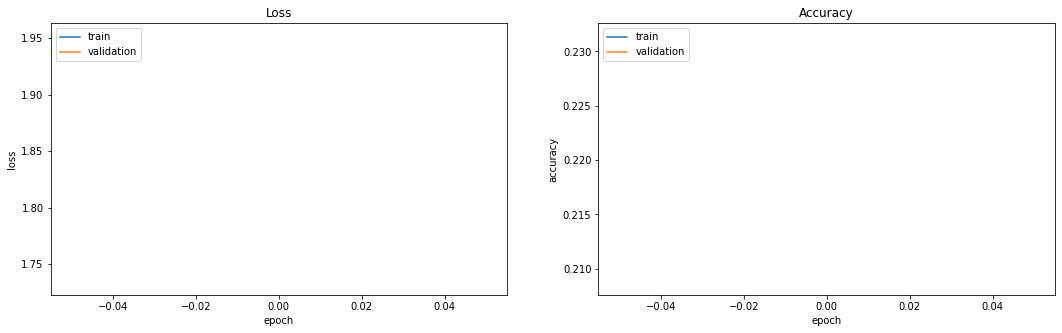

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig(output_folder + model_name + "_training_curves.png")

## Predict and Evaluate Model

In [18]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 24s 1s/step - loss: 1.7279 - accuracy: 0.2322


In [19]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 5s 2ms/step


In [20]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)

wa_prec = report["weighted avg"]["precision"]
wa_rec = report["weighted avg"]["recall"]
wa_f1 = report["weighted avg"]["f1-score"]

              precision    recall  f1-score   support

           0     0.1977    0.0567    0.0881       300
           1     0.0000    0.0000    0.0000       300
           2     0.0000    0.0000    0.0000       300
           3     0.1519    0.0480    0.0729       250
           4     0.1586    1.0000    0.2738       250
           5     0.5789    0.0550    0.1005       200
           6     0.0000    0.0000    0.0000       250
           7     0.0000    0.0000    0.0000       300
           8     0.2605    0.3240    0.2888       250
           9     0.4224    0.8533    0.5651       300

    accuracy                         0.2322      2700
   macro avg     0.1770    0.2337    0.1389      2700
weighted avg     0.1647    0.2322    0.1389      2700



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

In [21]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=cf_matrix, 
    index=class_name_list, 
    columns=class_name_list
)

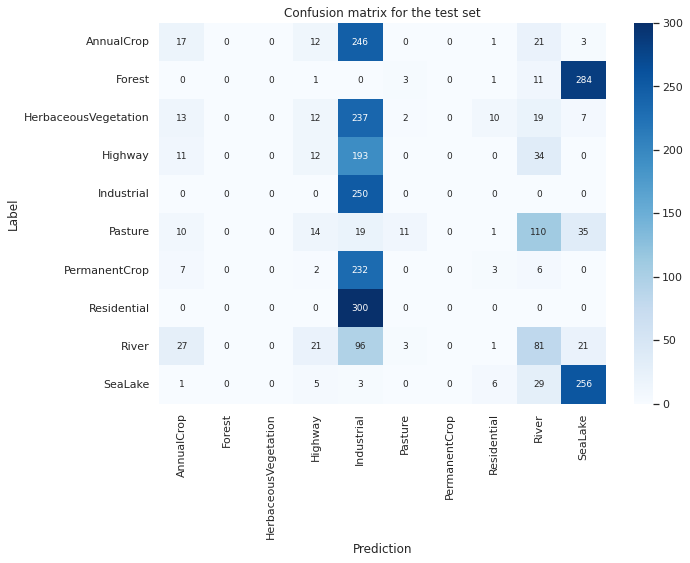

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig(output_folder + model_name + "_confusion.png")

In [23]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

wrong_preds = len(mistakes_df)
tot_preds = len(results_df)

print(f"{wrong_preds} wrong predictions out of {tot_preds}")

2073 wrong predictions out of 2700


In [24]:
# Add results to the results csv file:

with open("./results.csv", 'a+', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow([model,
                         "removed_layer", 
                         loss,
                         accuracy,
                         wa_prec,
                         wa_rec,
                         wa_f1,
                         wrong_preds,
                         tot_preds,
                         batch_size,
                         len(training_df), # number of images in the training set
                         len(validation_df), # number of images in the validation set
                         len(test_df), # number of images in the test set
                         n_epochs, # cap set for num epochs
                         n_ran_epochs # epoch where it stopped automatically
                        ])
    

# START ABLATION STUDY

In [25]:
def run_model(model, model_name):
    model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"
    # Save the weigths of the best model
    checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
    # Reduce learning rate when val_loss stops improving for 5 epochs.
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    # Stop training if a val_loss has stopped improving for 5 epochs.
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)
    callback_list = [checkpoint, early_stopping, reduce_lr]
    
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

    history = model.fit(
        training_set,
        validation_data=validation_set,
        callbacks=callback_list,
        epochs=n_epochs,
        verbose=0, # does not print epoch information
    )

    return history

In [26]:
def get_eval_metrics(history, model, test_set):
    n_ran_epochs = len(history.history['loss'])
    loss, accuracy = model.evaluate(test_set, verbose=1)
    test_set.reset()
    predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
    predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
    report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)
    wa_prec = report["weighted avg"]["precision"]
    wa_rec = report["weighted avg"]["recall"]
    wa_f1 = report["weighted avg"]["f1-score"]
    cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
    confusion_matrix_df = pd.DataFrame(
        data=cf_matrix, 
        index=class_name_list, 
        columns=class_name_list
    )
    results_df = pd.DataFrame(
        {
            "label": test_set.labels, 
            "prediction": predicted_class_ids, 
            "path": test_set.filepaths
        }
        )

    mistakes = results_df["label"] != results_df["prediction"]
    mistakes_df = results_df[mistakes]
    wrong_preds = len(mistakes_df)
    tot_preds = len(results_df)

    print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
    
    return n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds

    
    
def save_plots(history, output_folder, model_name, confusion_matrix_df):
    plt.subplot(1, 2, 1)
    # Loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - " + model_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - " + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    #plt.show()
    plt.savefig(output_folder + model_name + "_training_curves.png")
    
    # CONFUSION MATRIX IMAGE
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
    plt.ylabel("Label")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix - " + model_name)
    #plt.show()
    plt.savefig(output_folder + model_name + "_confusion.png")


In [27]:
def append_results_to_csv(csv_row):
    """Append the results to the csv file
    csv_row: list, contains the information to append to the csv"""
    
    with open("./results.csv", 'a+', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        # Create a row with the column names:
        filewriter.writerow(csv_row)

## Ablate CONV1

2700/2700 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0     0.2682    0.2333    0.2496       300
           1     0.0000    0.0000    0.0000       300
           2     1.0000    0.0133    0.0263       300
           3     0.2982    0.0680    0.1107       250
           4     0.3713    0.8480    0.5164       250
           5     0.3801    0.7850    0.5122       200
           6     0.0000    0.0000    0.0000       250
           7     0.2573    0.4100    0.3162       300
           8     0.2877    0.4200    0.3415       250
           9     0.4554    0.8333    0.5889       300

    accuracy                         0.3474      2700
   macro avg     0.3318    0.3611    0.2662      2700
weighted avg     0.3369    0.3474    0.2589      2700



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

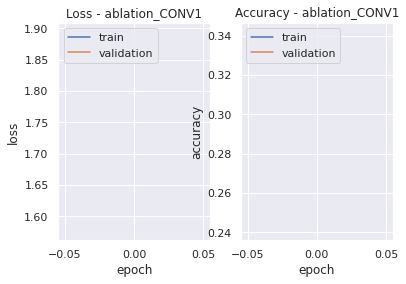

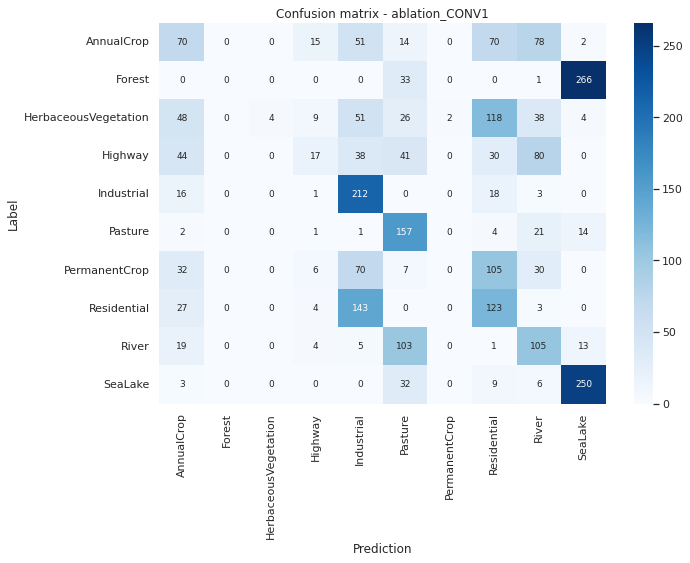

In [28]:
model_name = "ablation_CONV1"
model = Sequential()

# start of model
#model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV2

2700/2700 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0     0.2399    0.4567    0.3146       300
           1     0.4761    0.8967    0.6220       300
           2     0.6154    0.0800    0.1416       300
           3     0.3559    0.0840    0.1359       250
           4     0.4573    0.7280    0.5617       250
           5     0.4244    0.4350    0.4296       200
           6     0.0000    0.0000    0.0000       250
           7     0.3170    0.5400    0.3995       300
           8     0.3702    0.3880    0.3789       250
           9     0.2841    0.0833    0.1289       300

    accuracy                         0.3719      2700
   macro avg     0.3540    0.3692    0.3113      2700
weighted avg     0.3557    0.3719    0.3100      2700



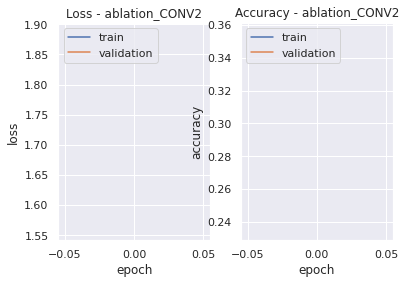

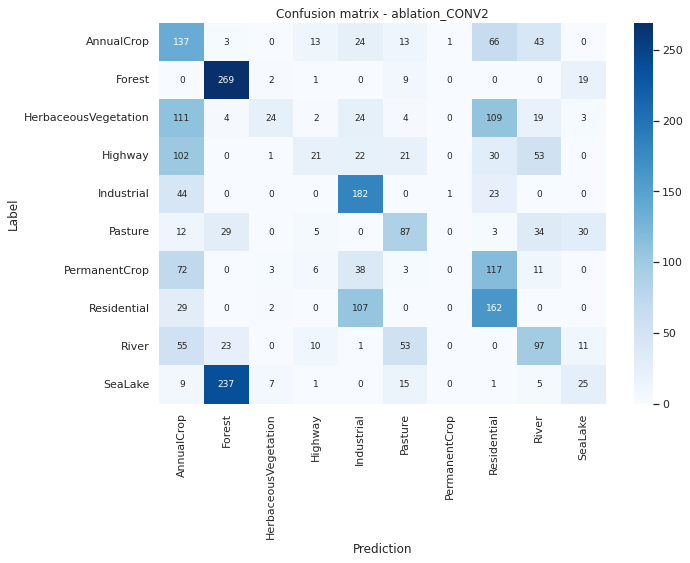

In [29]:
model_name = "ablation_CONV2"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV3

2700/2700 [==============================] - 4s 1ms/step
              precision    recall  f1-score   support

           0     0.4945    0.7533    0.5971       300
           1     0.4318    0.0633    0.1105       300
           2     0.4762    0.0333    0.0623       300
           3     0.3776    0.2160    0.2748       250
           4     0.6278    0.4520    0.5256       250
           5     0.4579    0.4350    0.4462       200
           6     0.4645    0.3400    0.3926       250
           7     0.4918    0.8967    0.6352       300
           8     0.3510    0.5040    0.4138       250
           9     0.4410    0.8467    0.5799       300

    accuracy                         0.4604      2700
   macro avg     0.4614    0.4540    0.4038      2700
weighted avg     0.4620    0.4604    0.4024      2700



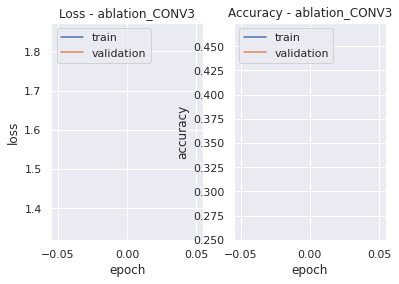

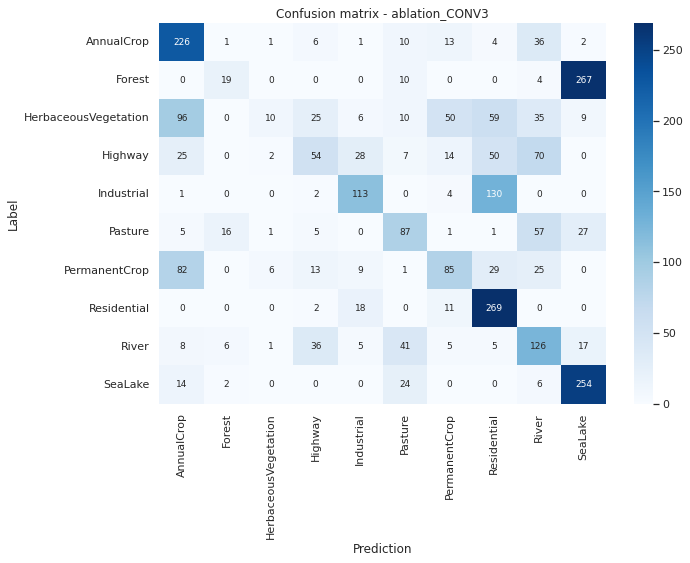

In [30]:
model_name = "ablation_CONV3"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV4

2700/2700 [==============================] - 4s 1ms/step
              precision    recall  f1-score   support

           0     0.3843    0.9467    0.5467       300
           1     0.5333    0.0800    0.1391       300
           2     0.0000    0.0000    0.0000       300
           3     0.3366    0.2760    0.3033       250
           4     0.4649    0.8480    0.6006       250
           5     0.4332    0.4050    0.4186       200
           6     0.3210    0.2080    0.2524       250
           7     0.7234    0.2267    0.3452       300
           8     0.3415    0.3880    0.3633       250
           9     0.4924    0.8667    0.6280       300

    accuracy                         0.4248      2700
   macro avg     0.4031    0.4245    0.3597      2700
weighted avg     0.4047    0.4248    0.3560      2700



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

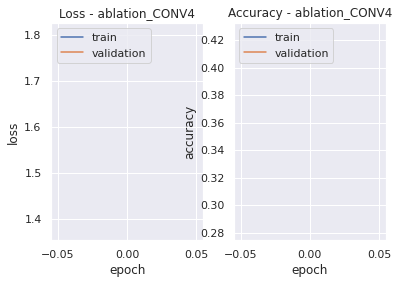

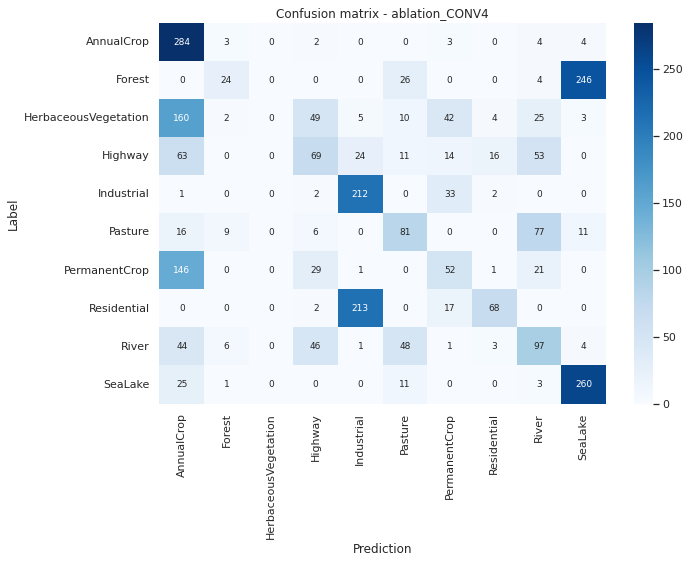

In [31]:
model_name = "ablation_CONV4"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV5

2700/2700 [==============================] - 4s 1ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           0     0.3086    0.9300    0.4635       300
           1     0.0000    0.0000    0.0000       300
           2     0.2200    0.0367    0.0629       300
           3     0.4304    0.1360    0.2067       250
           4     0.6631    0.7400    0.6994       250
           5     0.3922    0.4000    0.3960       200
           6     0.1124    0.0400    0.0590       250
           7     0.7234    0.5667    0.6355       300
           8     0.4667    0.2800    0.3500       250
           9     0.3732    0.8833    0.5248       300

    accuracy                         0.4089      2700
   macro avg     0.3690    0.4013    0.3398      2700
weighted avg     0.3645    0.4089    0.3385      2700



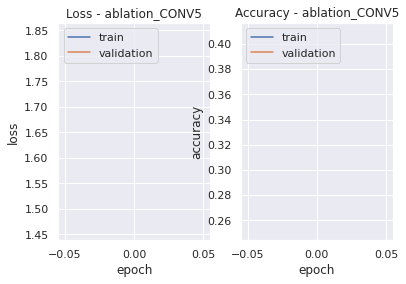

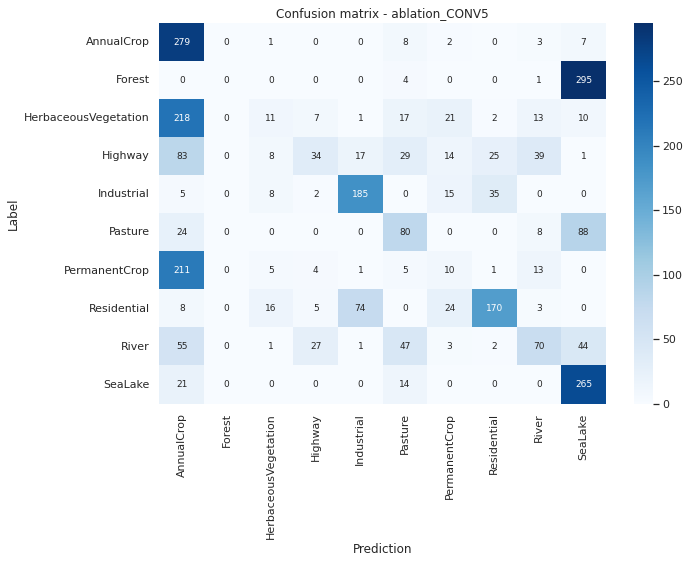

In [32]:
model_name = "ablation_CONV5"
model = Sequential()

model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)